In [52]:
'''
DeepDA_verify is to verify DA output.

1. Read proxy, prior, and posterior from DA outputs files and config file.
2. Convert proxy to temperature unit
3. Calculates the RMSE, CE, and r for the proxy-based temperature 
   and prior & posterior temperature for each ensemble members & each MC
4. Save and plot the outputs

By Mingsong Li
Penn State
2/17/2020
Updated Mar. 3. 2020
    for Monte Carlo simulations:
    
Updated Nov. 6, 2020
    for MacOS
'''
import sys
sys.path.append('../')
from DeepDA_lib import modules_nc
from DeepDA_lib import DeepDA_psm
from scipy import stats
import shutil

import h5py
#import time
import yaml
import numpy as np
import numpy.ma as ma

import pandas
import os
from netCDF4 import Dataset
from sys import platform as sys_pf
import matplotlib.pyplot as plt
if sys_pf == 'darwin':
    import matplotlib
    matplotlib.use("TkAgg")
    import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
try:
    import bayspline
except ImportError as e1:
    print('Warning:', e1)
try:
    import bayspar
except ImportError as e2:
    print('Warning:', e2)
try:
    import bayfox
except ImportError as e3:
    print('Warning:', e3)
try:
    import baymag
except ImportError as e4:
    print('Warning:', e4)

print('>>  Import package => OKAY')
print('')

###################################################################
#####################    User defined start   #####################
###################################################################

recon = 0  # 0 = prePETM; 1 = peakPETM

if recon == 0:
    #en = 'petmproxy3slices_v0.0.18.csv_petm17_v18_2021102_TOM_deepmip_MCsd100'
    #en = 'petmproxy3slices_v0.0.18.csv_petm22_v18_2021102_TOM_deepmip_MCsd50'
    #en = 'petmproxy3slices_v0.0.18.csv_petm17_v18_2021117_TOM_deepmip_Rscale7_MCsd100'
    #en = 'petmproxy3slices_v0.0.18.csv_petm17_v18_2021123_TOM_deepmip_R.5_MCsd100'
    en = 'petmproxy3slices_v0.0.18.csv_petm27_v18_20210224_TOM_Ca100_deepmip_3slice_MCsd100_R1'
    en = 'petmproxy3slices_v0.0.18.csv_petm27_v18_20210228_TOM_deepmip_MCsd100_testR'   # useful, no CaCO3 is needed as only sst proxy are used for the calculation
    xlsfilename = 'Tab.Sx.Rscale_CE&RMSE_petm27_v18_20210228_TOM_deepmip_MCsd100_testR.xlsx'
elif recon == 1:
    #en = 'petmproxy3slices_v0.0.18.csv_petm17_v18_2021102_TOM_deepmip_MCsd100'
    #en = 'petmproxy3slices_v0.0.18.csv_petm17_v18_2021123_TOM_deepmip_R.5_MCsd100'
    #en = 'petmproxy3slices_v0.0.18.csv_petm17_v18_2021117_TOM_deepmip_Rscale7_MCsd100'
    en = 'petmproxy3slices_v0.0.18.csv_petm18_v18_20210224_TOM_Ca100_deepmip_peakPETM_MCsd100_R1'
    #en = 'petmproxy3slices_v0.0.18.csv_petm18_v18_20210228_TOM_Ca100_deepmip_MCsd100_testR'
    en = 'petmproxy3slices_v0.0.18.csv_petm18_v18_20210228_TOM_Ca100_deepmip_MCsd100_testR10_1'
    en = 'petmproxy3slices_v0.0.18.csv_petm18_v18_20210228_TOM_deepmip_MCsd100_testR'  
    xlsfilename = 'Tab.Sx.Rscale_CE&RMSE_petm18_v18_20210228_TOM_deepmip_MCsd100_testR.xlsx'
AnalysisStd = False   # True: standardize; False: use raw analysis data

dum_jmax = 36
dum_imax = 36
dum_ijmax = dum_imax * dum_jmax

###################################################################
#####################     User defined end    #####################
###################################################################


# ------------------------------------
# Section 1: Load configuration files
# ------------------------------------


config_name_f = "DeepDA_config.yml"
f = open('../'+config_name_f, 'r')
yml_dict_f = yaml.load(f, Loader=yaml.FullLoader)
f.close()

dir_data_save = yml_dict_f['core']['wrkdir']

config_name = dir_data_save + '/' + en + '.yml'
f = open(config_name, 'r')
yml_dict = yaml.load(f, Loader=yaml.FullLoader)
f.close()
print('>>  Loading configuration file => OKAY')
print('')
# Read parameters from configurations
MCn = yml_dict['MonteCarlo']['number']

# debug & test
#MCn = 10

nens = yml_dict['core']['nens']

nexp = yml_dict['core']['nexp']
dir_data_save = yml_dict['core']['wrkdir']

recon_period = yml_dict['core']['recon_period']
recon_timescale = yml_dict['core']['recon_timescale_interval']
recon_period_full = np.arange(recon_period[0],recon_period[1]+1,recon_timescale)
recon_period_len = recon_period_full.shape[0]
recon_timescale = yml_dict['core']['recon_timescale_interval']
save_ens_full = yml_dict['core']['save_ens_full']
proxy_assim2 = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_assim2']
proxy_psm_type    = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_psm_type']
proxy_err_eval   = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_err_eval']
lon_label = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['lon_label']
lat_label = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['lat_label']

proxy_frac      = yml_dict['proxies']['proxy_frac']
prior_source = yml_dict['prior']['prior_source'] #
dum_lon_offset = yml_dict['prior'][prior_source]['dum_lon_offset'] # longitude offset
limit_hard_keys = list(yml_dict['prior'][prior_source]['limit_hard'].keys())
#print(limit_hard_keys)

data_period_id    = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['data_period_id']
data_period_idstd = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['data_period_idstd']
recon_period = yml_dict['core']['recon_period']
recon_timescale = yml_dict['core']['recon_timescale_interval']

psm_d18osw_adjust = yml_dict['psm']['bayesreg_d18o_pooled']['psm_d18osw_adjust']
d18osw_local_choice = yml_dict['psm']['bayesreg_d18o_pooled']['d18osw_local_choice']
d18osw_icesm_pco2 = yml_dict['psm']['bayesreg_d18o_pooled']['d18osw_icesm_pco2']
# bayspar
search_tol_i = yml_dict['psm']['bayesreg_tex86']['search_tol']
search_tol_file = yml_dict['psm']['bayesreg_tex86']['search_tol_file']

# debug & test ##
recon_period_full = np.arange(recon_period[0],recon_period[1]+1,recon_timescale)
recon_period_len = recon_period_full.shape[0]
recon_period_len = 1
 
geologic_age = yml_dict['core']['geologic_age']

# read preprior HDF5 file
dir_proxy_data = dir_data_save +'/'+ yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['dbversion']
proxy_err_eval = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_err_eval']

# read proxy raw file
proxy_dir = yml_dict['core']['proxy_dir']
proxy_rawfile = proxy_dir +'/'+ yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['dbversion']

try:
    proxy_tex_tol =  proxy_dir + '/' + search_tol_file
except:
    print('No file for bayspar settings')
### read proxies database ###
#proxies = pandas.read_csv(proxy_rawfile)
proxy_tex_tol = pandas.read_csv(proxy_tex_tol)
proxy_tex_tol_len = len(proxy_tex_tol)
#print(proxy_tex_tol)

# ========= read dataset for plot =========
cGENIEGrid = yml_dict['core']['proj_dir'] + '/data_misc/cGENIEGrid.csv'
cGENIEGrid = pandas.read_csv(cGENIEGrid)
cGENIEGridB_lat36 = cGENIEGrid['lat']
cGENIEGridB_lon36 = cGENIEGrid['lon']
cGENIEGrid = cGENIEGrid.to_numpy()
#print('>>  OKAY.')

# Read global mean and plot to show results



########## Prior #########

prior_state_variable = yml_dict['prior'][prior_source]['state_variable']  # note: ['2d': xxx; '3d': xxx]

# ========= Monte Carlo =========

local_rad_list = yml_dict['core']['local_rad_list'] #
locRadn= len(local_rad_list)
local_rad_list = np.asarray(local_rad_list)
#print(local_rad_list)
#print(locRadn)
proxy_frac_list   = yml_dict['proxies']['proxy_frac']
proxy_fracn = len(proxy_frac_list)
proxy_frac_list = np.asarray(proxy_frac_list)

Rscale_list = yml_dict['core']['Rscale']
Rscalen = len(Rscale_list)
print('Rscale n = {}'.format(Rscalen))
Rscale_list = np.asarray(Rscale_list)
MC_dir =  dir_data_save + '/' + en + '/'

# save prior variable list
prior_variable_dict = []  # variable list
prior_nc_file_list = []  # nc file list
prior_variable_dict_3d = []  # variable list
prior_nc_file_list_3d = []  # nc file list

for key, value in prior_state_variable.items():
    nc_keyvalue = prior_state_variable[key]['ncname']  # note: 2d dict
    print('>>  nc_keyvalue {}...'.format(nc_keyvalue))
    for key1, value1 in nc_keyvalue.items():
        print('>>  {}: {}'.format(key1,value1))
        for i in range(len(prior_state_variable[key][value1])):
            if key in ['2d']:
                prior_variable_dict.append(prior_state_variable[key][value1][i])
                prior_nc_file_list.append(key1+'/'+value1+'.nc')
            elif key in ['3d']:
                prior_variable_dict_3d.append(prior_state_variable[key][value1][i])
                prior_nc_file_list_3d.append(key1+'/'+value1+'.nc')

# variable list
prior_variable_len = len(prior_variable_dict)
prior_variable3d_len = len(prior_variable_dict_3d)
print('>>  Number of 2d prior variables is: {}. List:'.format(prior_variable_len))
print('      {}'.format(prior_variable_dict))
print('>>  Number of 3d prior variables is: {}. List:'.format(prior_variable3d_len))
print('      {}'.format(prior_variable_dict_3d))
print('Reading prior... Wait ...')
# ---------------------------------------
# Section 2: Define output variables
# ---------------------------------------
# 2d fields only
Xb2d_prior_np = np.full((dum_jmax*dum_imax,nens,locRadn,proxy_fracn,Rscalen,prior_variable_len),np.nan)  # save mean of each variable (column) of each MC run (row)
Xa2d_poste_np = np.full((dum_jmax*dum_imax,nens,locRadn,proxy_fracn,Rscalen,MCn,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)

# ---------------------------------------
# Section 3: Read output data
# ---------------------------------------

for locRadi in range(locRadn):
    locRad = local_rad_list[locRadi]
    if locRad is None:
        locRadv = 0 # for filename only
    else:
        locRadv = locRad
        
    for proxy_fraci in range(proxy_fracn):
        proxy_frac = proxy_frac_list[proxy_fraci]
        
        for Rscalei in range(Rscalen):
            Rscale = Rscale_list[Rscalei]
            print('>>{} of {} r-scale'.format(Rscalei, Rscalen))
            for MCi in range(MCn):
                if MCi % 20 == 0: print('>>  {} of {}'.format(MCi, MCn))
                # file names
                filename_short = '_loc_', str(locRadv),'_proxy_frac_', str(proxy_frac),'_Rscale_',str(Rscale),'_MC_' + str(MCi) 
                nc_filename = MC_dir + ''.join(filename_short) + '.nc'
                hdf5name    = MC_dir + ''.join(filename_short) + '.hdf5'
                
                if MCi == 0:
                    sites_eval   = pandas.read_hdf(hdf5name,'sites_eval')
                    sites_eval_n = len(sites_eval.index)
                
                #print('>>  Read nc file: {}'.format(nc_filename))
                
                for Xa2d_vari in range(prior_variable_len):
                    
                    Xb_full_name_vari = prior_variable_dict[Xa2d_vari] +'_Xb_full'
                    Xa_full_name_vari = prior_variable_dict[Xa2d_vari] +'_Xa_full'
                    Xa_mean_name_vari = prior_variable_dict[Xa2d_vari] +'_Xa_mean'
                    Xa_variance_name_vari = prior_variable_dict[Xa2d_vari] +'_Xa_variance'
                    # Mg/Ca
                    
                    #print('>>  2d variable name {}'.format(Xa_mean_name_vari))
                    Xb_full_vari = Dataset(nc_filename).variables[Xb_full_name_vari][:]
                    Xa_full_vari = Dataset(nc_filename).variables[Xa_full_name_vari][:]
                    Xa_mean_vari = Dataset(nc_filename).variables[Xa_mean_name_vari][:]
                    Xa_variance_vari = Dataset(nc_filename).variables[Xa_variance_name_vari][:]
                    if en in ['petmproxy3slices_v0.0.18.csv_petm18_v18_20210228_TOM_deepmip_MCsd100_testR']:
                        recon = 0
                    Xa_full_reconi = Xa_full_vari[:,:,:,0,recon].reshape((dum_ijmax,nens))
                    #print(Xa_full_reconi.shape)
                    Xa2d_poste_np[:,:,locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,0] = np.copy(Xa_full_reconi)
                        
                    if MCi == 0:
                        Xb_full_reconi = Xb_full_vari[:,:,:,0].reshape((dum_ijmax,nens))
                        Xb2d_prior_np[:,:,locRadi,proxy_fraci,Rscalei,Xa2d_vari] = np.copy(Xb_full_reconi)
                        
            Xb2d_prior_np = np.ma.masked_where(Xb2d_prior_np > 9.0e+36, Xb2d_prior_np)
            Xa2d_poste_np = np.ma.masked_where(Xa2d_poste_np > 9.0e+36, Xa2d_poste_np)
            
print('>>  Prior read. Done')
print(Xb2d_prior_np.shape)
print(Xa2d_poste_np.shape)
#print(Xb2d_prior_np[180,:])

>>  Import package => OKAY

>>  Loading configuration file => OKAY

Rscale n = 1
>>  nc_keyvalue {'biogem': 'fields_biogem_2d', 'sedgem': 'fields_sedgem_2d'}...
>>  biogem: fields_biogem_2d
>>  sedgem: fields_sedgem_2d
>>  nc_keyvalue {'biogem': 'fields_biogem_3d'}...
>>  biogem: fields_biogem_3d
>>  Number of 2d prior variables is: 7. List:
      ['ocn_sur_temp', 'atm_temp', 'atm_pCO2', 'ocn_sur_sal', 'misc_pH', 'carb_sur_ohm_cal', 'sed_CaCO3']
>>  Number of 3d prior variables is: 0. List:
      []
Reading prior... Wait ...
>>0 of 1 r-scale
>>  0 of 100
>>  20 of 100
>>  40 of 100
>>  60 of 100
>>  80 of 100
>>  Prior read. Done
(1296, 100, 1, 1, 1, 7)
(1296, 100, 1, 1, 1, 100, 7, 1)


In [53]:
# bayspar can be time consuming. do it first

### read proxies database ###
proxies = pandas.read_csv(proxy_rawfile)
# add a new colum
proxies["sst_bayspar"] = ""

for index, row in proxies.iterrows():
    
    filei = row['File']
    
    if row['Type'] in ['TEX86','tex86','Tex86']:
        
        obi = row[data_period_id[recon]]
        
        # search for tol information
        tol_row = proxy_tex_tol.loc[proxy_tex_tol['File'] == filei]
        #print(tol_row)
        #print(tol_row['mean'].iloc[0])
        prediction = bayspar.predict_seatemp_analog(tex = np.array([obi]),
                                                    temptype='sst',
                                                    prior_mean=tol_row['mean'].iloc[0],
                                                    prior_std=10,
                                                    search_tol=tol_row['tol'].iloc[0],
                                                    nens = 2500)
        proxies["sst_bayspar"][index] = np.mean(prediction.ensemble)
        print('{} - {} TEX86: {} SST: {}'.format(data_period_id[recon], row['File'], row[data_period_id[recon]],np.mean(prediction.ensemble)))

100%|██████████| 41/41 [00:04<00:00,  9.31it/s]
/Users/mingsongli/miniconda3/envs/deepda/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  7%|▋         | 1/15 [00:00<00:01,  7.16it/s]

prePETMmean - sluijs2006-acex302-4a.txt TEX86: 0.6081818179999999 SST: 22.663950958328872


  3%|▎         | 1/36 [00:00<00:04,  7.84it/s]

prePETMmean - Frieling et al., 2019 TEX86: 0.859222222 SST: 36.66924620514521


  3%|▎         | 1/32 [00:00<00:03,  7.76it/s]

prePETMmean - bijl2009-1172.txt TEX86: 0.6295 SST: 24.653843387789745


  5%|▍         | 1/22 [00:00<00:02,  9.31it/s]

prePETMmean - sluijs2011-odpsite1172.txt TEX86: 0.6555 SST: 26.218428863240465


  2%|▏         | 1/50 [00:00<00:05,  8.25it/s]

prePETMmean - sluijs2007-bassriver.txt TEX86: 0.762 SST: 31.84580948163138


  2%|▏         | 1/41 [00:00<00:04,  8.61it/s]

prePETMmean - schoon2013-fursectionnorthsea.txt TEX86: 0.53 SST: 18.187733375514306


  2%|▏         | 1/49 [00:00<00:05,  8.91it/s]

prePETMmean - Stokke2020-TEX-Fur TEX86: 0.6134144460000001 SST: 23.215603618998475


  4%|▎         | 1/27 [00:00<00:03,  6.56it/s]

prePETMmean - schoon2013-storebaelt.txt TEX86: 0.5314300000000001 SST: 18.299327895447142


  5%|▌         | 1/20 [00:00<00:02,  7.89it/s]

prePETMmean - sluijs2014-harrellcore.txt TEX86: 0.72619 SST: 30.1087073180096


  5%|▌         | 1/19 [00:00<00:02,  8.12it/s]

prePETMmean - frieling2017-ib10aofnigeria.txt TEX86: 0.8336399999999999 SST: 35.910961988125436


  6%|▋         | 1/16 [00:00<00:01,  8.40it/s]

prePETMmean - frieling2017-ib10bofnigeria.txt TEX86: 0.838439605 SST: 36.1868544854475


  6%|▌         | 1/18 [00:00<00:02,  7.51it/s]

prePETMmean - Smith et al. 2020 TEX86: 0.856268312 SST: 36.654100553065334


  2%|▏         | 1/49 [00:00<00:06,  7.10it/s]

prePETMmean - frieling2017-sqofnigeriatex86.txt TEX86: 0.84429 SST: 36.34765613768602


100%|██████████| 49/49 [00:05<00:00,  8.48it/s]
0it [00:00, ?it/s]
  3%|▎         | 1/29 [00:00<00:04,  6.20it/s]

prePETMmean - hollis2012-waiparatex-mgca-d18o.txt TEX86: 0.5373 SST: 19.410961019519416
prePETMmean - frieling2014-westsiberian.txt TEX86: nan SST: nan


100%|██████████| 29/29 [00:03<00:00,  8.18it/s]

prePETMmean - zachos2006-wilsonlake.txt TEX86: 0.698 SST: 28.399998014555123


In [54]:
# ---------------------------------------
# Section 4: Read proxy dataframe, calculate SST
# ---------------------------------------
from DeepDA_lib import DeepDA_psm
sst_proxy_MC = np.full((sites_eval_n,locRadn,proxy_fracn,Rscalen,MCn,recon_period_len),np.nan)
sst_prior_MC = np.full((nens,sites_eval_n,locRadn,proxy_fracn,Rscalen,MCn,recon_period_len),np.nan)
sst_poste_MC = np.full((nens,sites_eval_n,locRadn,proxy_fracn,Rscalen,MCn,recon_period_len),np.nan)

ce_prior = np.full((nens,Rscalen,MCn),np.nan)
ce_poste = np.full((nens,Rscalen,MCn),np.nan)

rmse_prior = np.full((nens,Rscalen,MCn),np.nan)
rmse_poste = np.full((nens,Rscalen,MCn),np.nan)

rho_prior = np.full((nens,Rscalen,MCn),np.nan)
rho_poste = np.full((nens,Rscalen,MCn),np.nan)

for locRadi in range(locRadn):
    locRad = local_rad_list[locRadi]
    if locRad is None:
        locRadv = 0 # for filename only
    else:
        locRadv = locRad
        
    for proxy_fraci in range(proxy_fracn):
        proxy_frac = proxy_frac_list[proxy_fraci]
        
        for Rscalei in range(Rscalen):
            Rscale = Rscale_list[Rscalei]
            
            for MCi in range(MCn):
                
                if MCi % 20 == 0: print('>>  {} of {}'.format(MCi, MCn))
                
                # file names
                filename_short = '_loc_', str(locRadv),'_proxy_frac_', str(proxy_frac),'_Rscale_',str(Rscale),'_MC_' + str(MCi) 
                nc_filename = MC_dir + ''.join(filename_short) + '.nc'
                hdf5name    = MC_dir + ''.join(filename_short) + '.hdf5'
                
                sites_eval  = pandas.read_hdf(hdf5name,'sites_eval')
                #print(sites_eval)
                proxy_psm_type_dict = {}
                sites_eval_n = len(sites_eval.index)
                
                #print(sites_eval_n)
                for index, row in sites_eval.iterrows():
                    
                    #for sitei in range(sites_eval_len):
                    proxy_type_i = row['Proxy']
                    
                    data_psm_type_find = 0
                    for key, value in proxy_assim2.items():
                        if proxy_type_i in proxy_assim2[key]:
                            data_psm_type_find = data_psm_type_find + 1
                    if data_psm_type_find == 1:
                        for key, value in proxy_psm_type.items():
                            if proxy_type_i in proxy_assim2[key]:
                                data_psm_key = key
                        proxy_psm_type_i = proxy_psm_type[data_psm_key]
                        #print(proxy_type_i)

                        proxy_psm_type_dict[index] =proxy_psm_type_i
                        
                        data_period_i = data_period_id[recon]
                        #print(data_period_i)
                        
                        obi = row[data_period_i]
                        filei = row['File']
                        # location and grid id
                        dum_lat = row[lat_label]  # (paleo)latitude of this site
                        dum_lon = row[lon_label]  # (paleo)longitude of this site
                        lonlat = modules_nc.cal_find_ij(dum_lon,dum_lat,dum_lon_offset,dum_imax,dum_jmax)
                        # output [lon, lat], 
                        # lon ranges from 0 (-180) to 35 (180), lat ranges from 0 (-90) to 35 (90)
                        # find 1d grid location [DeepDA, here is SST]
                        lonlati = lonlat[1] * dum_jmax + lonlat[0]
                        
                        # prior
                        sst_prior_MC[:,index,locRadi,proxy_fraci,Rscalei,MCi,recon_period_len-1] = Xb2d_prior_np[lonlati,:,locRadi,proxy_fraci,Rscalei,0]
                        # posterior
                        # Xa2d_poste_np[:,:,locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,recon]
                        sst_poste_MC[:,index,locRadi,proxy_fraci,Rscalei,MCi,recon_period_len-1] = Xa2d_poste_np[lonlati,:,locRadi,proxy_fraci,Rscalei,MCi,0,0]
                        
                        # proxy
                        
                        if proxy_psm_type_i in ['deepmip_d18o']:
                            if d18osw_local_choice in ['zachos94']:
                                # d18o_localsw using method by Zachos et al., 1994 PALEOCEANOGRAPHY
                                d18o_localsw = DeepDA_psm.d18o_localsw(abs(dum_lat))
                            else:
                                if d18osw_icesm_pco2 == 1.0:
                                    proxy_col_d18osw = 'd18osw_1x'
                                elif d18osw_icesm_pco2 == 3.0:
                                    proxy_col_d18osw = 'd18osw_3x'
                                elif d18osw_icesm_pco2 == 6.0:
                                    proxy_col_d18osw = 'd18osw_6x'
                                elif d18osw_icesm_pco2 == 9.0:
                                    proxy_col_d18osw = 'd18osw_9x'
                                else:
                                    proxy_col_d18osw = 'd18osw_3x'
                                d18o_localsw = row[proxy_col_d18osw]
                            datai = DeepDA_psm.d18o_linear(obi,d18o_localsw,2)

                            sst_proxy_MC[index,locRadi,proxy_fraci,Rscalei,MCi,recon_period_len-1] = np.copy(datai)
                            #print(proxy_type_i)
                            
                        elif proxy_psm_type_i in ['deepmip_mgca']:
                            # read prior again
                            ocn_sur_sal_Xb_full = Dataset(nc_filename).variables['ocn_sur_sal_Xb_full'][lonlat[1],lonlat[0],:,0]
                            misc_pH_Xb_full = Dataset(nc_filename).variables['misc_pH_Xb_full'][lonlat[1],lonlat[0],:,0]
                            carb_ohm_cal_Xb_full = Dataset(nc_filename).variables['carb_sur_ohm_cal_Xb_full'][lonlat[1],lonlat[0],:,0]
                            
                            salinity = np.mean(ocn_sur_sal_Xb_full)
                            ph = np.mean(misc_pH_Xb_full)
                            mgcasw = np.mean(carb_ohm_cal_Xb_full)

                            mgca = DeepDA_psm.mgca_sal_corr(obi,salinity)
                            datai = DeepDA_psm.mgca_evans18(mgca,ph,mgcasw)
                            
                            sst_proxy_MC[index,locRadi,proxy_fraci,Rscalei,MCi,recon_period_len-1] = np.copy(datai)
                            if MCi == 0 and Rscalei == 0: print('psm type {}, obs {}, sal_corr {}, ph {}, mgcasw {}, sst {}'.format(proxy_psm_type_i,obi,mgca,ph,mgcasw,datai))
                                
                        elif proxy_psm_type_i in ['bayesreg_tex86']:
                            # search for tol information
                            sst_row = proxies.loc[proxies['File'] == filei]
                            datai = sst_row['sst_bayspar']
                            sst_proxy_MC[index,locRadi,proxy_fraci,Rscalei,MCi,recon_period_len-1] = np.copy(datai)
                            
                        if MCi == 0 and Rscalei == 0: print('psm type {}, sst {}'.format(proxy_psm_type_i,datai))
            
            data = sst_proxy_MC[:,locRadi,proxy_fraci,Rscalei,:,recon_period_len-1]
            
            for ensi in range(nens):
                modelb = sst_prior_MC[ensi,:,locRadi,proxy_fraci,Rscalei,:,recon_period_len-1]
                ce_prior[ensi,Rscalei,:]=DeepDA_psm.CE_NS70(data, modelb, 1)
                
                modela = sst_poste_MC[ensi,:,locRadi,proxy_fraci,Rscalei,:,recon_period_len-1]
                ce_poste[ensi,Rscalei,:]=DeepDA_psm.CE_NS70(data, modela, 1)
                
                for MCj in range(MCn):
                    rmse_prior[ensi,Rscalei,MCj] = DeepDA_psm.rmse(data[:,MCj], modelb[:,MCj])
                    rmse_poste[ensi,Rscalei,MCj] = DeepDA_psm.rmse(data[:,MCj], modela[:,MCj])
                    
                    cor1 = ma.corrcoef(ma.masked_invalid(data[:,MCj]),ma.masked_invalid(modelb[:,MCj]),rowvar=False)
                    rho_prior[ensi,Rscalei,MCj] = cor1[0,1]
                    cor1 = ma.corrcoef(ma.masked_invalid(data[:,MCj]),ma.masked_invalid(modela[:,MCj]),rowvar=False)
                    rho_poste[ensi,Rscalei,MCj] = cor1[0,1]

>>  0 of 100
psm type deepmip_d18o, sst 12.937471280180446
psm type deepmip_d18o, sst 19.5814520481
psm type deepmip_mgca, obs 3.54245, sal_corr 3.605068494502198, ph 7.654859008789063, mgcasw 6.624763793945313, sst 17.94351488301183
psm type deepmip_mgca, sst 17.94351488301183
psm type deepmip_mgca, obs 3.4398699999999995, sal_corr 3.500675228213037, ph 7.654859008789063, mgcasw 6.624763793945313, sst 17.59666234086486
psm type deepmip_mgca, sst 17.59666234086486
psm type deepmip_d18o, sst 21.4828246809
psm type bayesreg_tex86, sst 35    24.6538
Name: sst_bayspar, dtype: object
psm type bayesreg_tex86, sst 36    26.2184
Name: sst_bayspar, dtype: object
psm type deepmip_mgca, obs 3.58725, sal_corr 3.642258727163086, ph 7.64619140625, mgcasw 6.65708251953125, sst 18.02288880534049
psm type deepmip_mgca, sst 18.02288880534049
psm type deepmip_mgca, obs 3.58, sal_corr 3.634897551953125, ph 7.64619140625, mgcasw 6.65708251953125, sst 17.998949177126594
psm type deepmip_mgca, sst 17.9989491

In [55]:
#print(sst_MCi)
print(proxy_psm_type_dict)

output_np = np.full((3,Rscalen+1),np.nan)

for locRadi in range(locRadn):
    locRad = local_rad_list[locRadi]
    if locRad is None:
        locRadv = 0 # for filename only
    else:
        locRadv = locRad
        
    for proxy_fraci in range(proxy_fracn):
        proxy_frac = proxy_frac_list[proxy_fraci]
        
        for Rscalei in range(Rscalen):
            
            print('R scale = {}'.format(Rscale_list[Rscalei]))
            
            if Rscalei==0: 
                print('CE prior: {}'.format(ce_prior[:,Rscalei,:].mean()))
            
            print('CE poste: {}'.format(ce_poste[:,Rscalei,:].mean()))
            
            if Rscalei==0: 
                print('RMSE prior: {}'.format(np.nanmean(rmse_prior[:,Rscalei,:])))
            
            print('RMSE poste: {}'.format(np.nanmean(rmse_poste[:,Rscalei,:])))
            print('')
            
            if Rscalei==0:
                output_np[1,0] = ce_prior[:,Rscalei,:].mean()
                output_np[2,0] = np.nanmean(rmse_prior[:,Rscalei,:])
                
            output_np[0,Rscalei+1] = Rscale_list[Rscalei]
            output_np[1,Rscalei+1] = ce_poste[:,Rscalei,:].mean()
            output_np[2,Rscalei+1] = np.nanmean(rmse_poste[:,Rscalei,:])
np.set_printoptions(precision=4)
print(output_np)

df = pandas.DataFrame (output_np)
#filepath = 'Tab.Sx.Rscale_CE&RMSE_prePETM027_testR1.xlsx'
filepath = xlsfilename
df.to_excel(filepath, index=False)

{0: 'deepmip_d18o', 1: 'bayesreg_tex86', 2: 'deepmip_d18o', 3: 'deepmip_mgca', 4: 'deepmip_d18o', 5: 'deepmip_d18o', 6: 'deepmip_mgca', 7: 'deepmip_mgca', 8: 'deepmip_mgca', 9: 'deepmip_d18o', 10: 'bayesreg_tex86', 11: 'bayesreg_tex86', 12: 'deepmip_d18o', 13: 'deepmip_d18o', 14: 'deepmip_d18o', 15: 'deepmip_mgca', 16: 'bayesreg_tex86', 17: 'deepmip_d18o', 18: 'deepmip_d18o', 19: 'deepmip_d18o', 20: 'bayesreg_tex86'}
R scale = 1.0
CE prior: -1.3307292244193565
CE poste: -0.427329046273608
RMSE prior: 9.6373924477304
RMSE poste: 7.623817174293917

[[    nan  1.    ]
 [-1.3307 -0.4273]
 [ 9.6374  7.6238]]


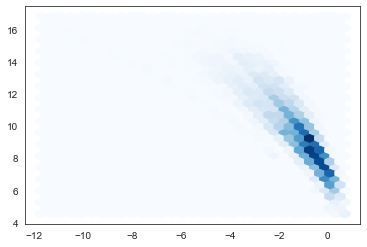

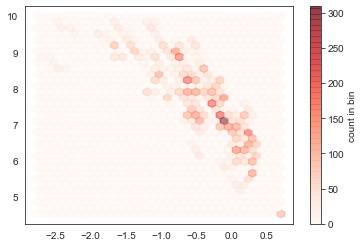

In [25]:
#fig = plt.figure()
#plt.hist(ce_prior.reshape(nens*MCn,1),alpha=0.5, bins=50)
#fig = plt.figure()
#plt.hist(ce_poste.reshape(nens*MCn,1),alpha=0.5, bins=50)

fig = plt.figure()
x = ce_prior.reshape(nens*MCn,1)
y = rmse_prior.reshape(nens*MCn,1)
plt.hexbin(x, y, gridsize=30, cmap='Blues', alpha=1)
#cb = plt.colorbar(label='count in bin')
fig = plt.figure()
z = ce_poste.reshape(nens*MCn,1)
w = rmse_poste.reshape(nens*MCn,1)
plt.hexbin(z, w, gridsize=30, cmap='Reds', alpha=0.5)
cb = plt.colorbar(label='count in bin')

[[-4.6175 13.9107]
 [-2.3354 13.5895]
 [-3.2041 14.3466]
 ...
 [ 0.0699  6.7585]
 [-0.8508  7.6705]
 [-1.5254  9.549 ]]
            CE       RMSE
0    -4.617475  13.910750
1    -2.335384  13.589466
2    -3.204096  14.346597
3    -1.915116  12.992058
4    -3.408426  15.430287
...        ...        ...
9995 -0.484779   8.241891
9996 -0.992013   8.341675
9997  0.069926   6.758541
9998 -0.850751   7.670489
9999 -1.525362   9.548990

[10000 rows x 2 columns]


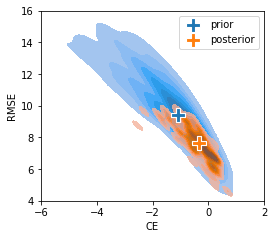

In [57]:
x = ce_prior.reshape(nens*MCn,1)
y = rmse_prior.reshape(nens*MCn,1)
z = ce_poste.reshape(nens*MCn,1)
w = rmse_poste.reshape(nens*MCn,1)

data1 = np.array([x,y]).reshape((2,nens*MCn))
data1 = np.swapaxes(data1,0,1)
data2 = np.array([z,w]).reshape((2,nens*MCn))
data2 = np.swapaxes(data2,0,1)
print(data1)
dfxy = pandas.DataFrame(data=data1,columns=['CE','RMSE'])
dfzw = pandas.DataFrame(data=data2,columns=['CE','RMSE'])
print(dfxy)

#data3 = np.array([[np.median(x),np.median(y)],[np.median(z),np.median(w)]])
# median
#data3 = np.array([np.median(x),np.median(y)]).reshape((1,2))
#data4 = np.array([np.median(z),np.median(w)]).reshape((1,2))
# mean
data3 = np.array([np.mean(x),np.mean(y)]).reshape((1,2))
data4 = np.array([np.mean(z),np.mean(w)]).reshape((1,2))

dfmedian1 = pandas.DataFrame(data=data3,columns=['CE','RMSE'])
dfmedian2 = pandas.DataFrame(data=data4,columns=['CE','RMSE'])

fig = plt.figure(figsize=(4,3.5))

sns.kdeplot(data = dfxy, x="CE", y = "RMSE",fill=True, levels=10,alpha=1)
sns.kdeplot(data = dfzw, x="CE", y = "RMSE",fill=True, levels=10,alpha=.8)

sns.scatterplot(data = dfmedian1, x="CE", y = "RMSE", s=200, color="C0", marker='P',label="prior")
sns.scatterplot(data = dfmedian2, x="CE", y = "RMSE", s=200, color="C1", marker='P',label="posterior")

plt.xlim([-6,2])
plt.ylim([4,16])
if recon == 0:
    fig.savefig(yml_dict['core']['proj_dir']+'/wrk/'+en+'.RMSE&CE_prePETM_mean.pdf')
else:
    fig.savefig(yml_dict['core']['proj_dir']+'/wrk/'+en+'.RMSE&CE_peakPETM_mean.pdf')

In [12]:
print('OLD or test codes below')

OLD or test codes below


In [ ]:
print(lonlat)

import numpy.ma as ma

print(data.shape)
print(modela.shape)
print(ma.corrcoef(ma.masked_invalid(data[:,0:3]),ma.masked_invalid((modela[:,0:3])),rowvar=False))

In [ ]:
data3 = np.array([np.median(x),np.median(y)]).reshape((1,2))
data4 = np.array([np.median(z),np.median(w)]).reshape((1,2))
dfmedian1 = pandas.DataFrame(data=data3,columns=['CE','RMSE'])
dfmedian2 = pandas.DataFrame(data=data4,columns=['CE','RMSE'])

sns.scatterplot(data = dfxy, x="CE", y = "RMSE", s=5, color=".15")
sns.kdeplot(data = dfxy, x="CE", y = "RMSE",fill=True, levels=5,alpha=.5)
sns.scatterplot(data = dfmedian1, x="CE", y = "RMSE", s=100, color="b", marker='P')
fig = plt.figure()
sns.scatterplot(data = dfzw, x="CE", y = "RMSE", s=5, color=".15")
sns.kdeplot(data = dfzw, x="CE", y = "RMSE",fill=True, levels=5,alpha=.5)
sns.scatterplot(data = dfmedian2, x="CE", y = "RMSE", s=100, color="r", marker='P')


data1 = np.array([x,y]).reshape((2,nens*MCn))
data1 = np.swapaxes(data1,0,1)
data2 = np.array([z,w]).reshape((2,nens*MCn))
data2 = np.swapaxes(data2,0,1)
print(data1)
dfxy = pandas.DataFrame(data=data1,columns=['CE','RMSE'])
dfzw = pandas.DataFrame(data=data2,columns=['CE','RMSE'])
print(dfxy)
sns.kdeplot(data = dfxy, x="CE", y = "RMSE",fill=True)
sns.kdeplot(data = dfzw, x="CE", y = "RMSE",fill=True)

In [ ]:
# test rho, RMSE and CE

for locRadi in range(locRadn):
    locRad = local_rad_list[locRadi]
    if locRad is None:
        locRadv = 0 # for filename only
    else:
        locRadv = locRad
        
    for proxy_fraci in range(proxy_fracn):
        proxy_frac = proxy_frac_list[proxy_fraci]
        
        for Rscalei in range(Rscalen):
            Rscale = Rscale_list[Rscalei]
            
            data = sst_proxy_MC[:,locRadi,proxy_fraci,Rscalei,:,recon_period_len-1]
            
            print('data')
            print(data)
            print('')
            for ensi in range(1):
                
                modelb = sst_prior_MC[ensi,:,locRadi,proxy_fraci,Rscalei,:,recon_period_len-1]
                
                ce_prior1=DeepDA_psm.CE_NS70(data[:,0], modelb[:,0], 1)
                
                modela = sst_poste_MC[ensi,:,locRadi,proxy_fraci,Rscalei,:,recon_period_len-1]
                
                ce_poste1 = DeepDA_psm.CE_NS70(data[:,0], modela[:,0], 1)
                
                print('modelb')
                print(modelb)
                print('')
                print('ce_prior1')
                print(ce_prior1)
                print('')
                print('modela')
                print(modela)
                print('')
                print('ce_poste1')
                print(ce_poste1)
                print('')
                print('rho prior 1')
                print(rho_prior[ensi,0])
                print('')                
                print('rho poste 1')
                print(rho_poste[ensi,0])
                print('')
                
                for MCj in range(1):
                    rmse_prior1= DeepDA_psm.rmse(data[:,MCj], modelb[:,MCj])
                    rmse_poste1= DeepDA_psm.rmse(data[:,MCj], modela[:,MCj])
                    print('rmse_prior1')
                    print(rmse_prior1)
                    print('')
                    print('rmse_poste1')
                    print(rmse_poste1)
                    print('')
                
                df = pandas.DataFrame (data)
                filepath = 'proxy_data.xlsx'
                df.to_excel(filepath, index=False)
                
                df = pandas.DataFrame (modelb)
                filepath = 'proxy_modelb.xlsx'
                df.to_excel(filepath, index=False)
                
                df = pandas.DataFrame (modela)
                filepath = 'proxy_modela.xlsx'
                df.to_excel(filepath, index=False)
                
                #df = pandas.DataFrame (ce_prior1)
                #filepath = 'proxy_ce_prior1.xlsx'
                #df.to_excel(filepath, index=False)
                
                #df = pandas.DataFrame (ce_poste1)
                #filepath = 'proxy_ce_poste1.xlsx'
                #df.to_excel(filepath, index=False)

In [130]:
'''
Read proxy, calculate temperate, save output in lmwrk/wrk/ folder
Use this as 'data', use prior, and posterior for comparison
'''

mgsoption = 1 # 1 = evans model; 2 = baymag surface model

if mgsoption == 1:
    sstproxyfileEvans = 'petmproxy3slices_v0.0.12_sst_evans.csv'
    proxy_rawfile = proxy_dir +'/'+ sstproxyfileEvans
else:
    sstproxyfileBaymag = 'petmproxy3slices_v0.0.12_sst_mg_sur.csv'
    proxy_rawfile = proxy_dir +'/'+ sstproxyfileBaymag 

print(' ########## Read proxies database ########## ')

### read proxies database ###
proxies = pandas.read_csv(proxy_rawfile)
proxies_len0 = len(proxies)

print(' {}'.format(proxy_rawfile))
print(' len is {}'.format(proxies_len0))

proxy_order       = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_order']
proxy_blacklist   = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_blacklist']
proxy_list = [item for item in proxy_order if item not in proxy_blacklist]
proxy_d18o_glassy  = yml_dict['proxies']['proxy_d18o_glassy']
proxy_assim3 = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_assim3']
data_glassy_label_blacklist = proxy_assim3['Marine sediments_d18o_pooled_glassy']

proxy_select_0 = 0

for j in range(proxies_len0):
    # Read proxy type from the database
    data_psm_type = proxies['Proxy'][j]
    # initial default 0 : this proxy is not included
    data_assimilate_i = 0
    for jlist in range(len(proxy_list)):
        if data_psm_type in proxy_assim2[proxy_list[jlist]]:
            # find and save this proxy
            data_assimilate_i = 1
    if data_assimilate_i == 1:
        #print('>>    file {}, {} included'.format(proxies.loc[j,'File'], data_psm_type))
        if proxy_select_0 == 0:
            proxy_select0 = proxies.iloc[[j]]
            proxy_select0 = proxy_select0.reset_index(drop=True) # reset_index, avoid index error
            proxy_select_0 = 1
        else:
            #proxy_select.append(proxies.iloc[[j]])
            proxy_select0 = proxy_select0.append(proxies.iloc[[j]], ignore_index=True)
#print('proxy selected {}'.format(proxy_select0))

proxies_select_len0 = len(proxy_select0)
print('>>  Proxy: selected proxy dataset number {}: those in blacklist removed'.format(proxies_select_len0))

### check glassy only data or not
proxy_select_0 = 0
if proxy_d18o_glassy:
    for jj in range(proxies_select_len0):
        data_glassy_label = proxy_select0['Glassy'][jj]
        if data_glassy_label not in data_glassy_label_blacklist:
            if proxy_select_0 == 0:
                proxy_select = proxy_select0.iloc[[jj]]
                proxy_select = proxy_select.reset_index(drop=True) # reset_index, avoid index error
                proxy_select_0 = 1
            else:
                proxy_select = proxy_select.append(proxy_select0.iloc[[jj]], ignore_index=True)

    #print(proxy_select)
    proxies_select_len0 = len(proxy_select)
    print('>>  Proxy: selected proxy dataset number {}: remove those unknown/frosty'.format(proxies_select_len0))
else:
    proxy_select = proxy_select0.copy()
#print(proxy_select)

 ########## Read proxies database ########## 
 /mnt/c/Users/mul450/Dropbox/git/deepDA/mlwrk/proxy/petmproxy3slices_v0.0.12_sst_evans.csv
 len is 41
>>  Proxy: selected proxy dataset number 41: those in blacklist removed
>>  Proxy: selected proxy dataset number 41: remove those unknown/frosty


In [ ]:
nens1 = 75
petm007sst = np.full((dum_jmax,dum_imax,nens1),np.nan)
petm007dir = '/mnt/d/cGENIE/ML.petm/ML.petm007/'
petm008sst = np.full((dum_jmax,dum_imax,nens1),np.nan)
petm008dir = '/mnt/d/cGENIE/ML.petm/ML.petm008/'

for idi in range(nens1):
    
    file7i = petm007dir + 'ML.petm007.ID.' + str(idi+1) + '/biogem/fields_biogem_2d.nc' 
    file8i = petm008dir + 'ML.petm008.ID.' + str(idi+1) + '/biogem/fields_biogem_2d.nc'
    print('{} : {} & {}'.format(idi+1, file7i, file8i))
    file7i_i = Dataset(file7i).variables['ocn_sur_temp'][12,:,:]
    petm007sst[:,:,idi] = np.copy(file7i_i)
    file8i_i = Dataset(file8i).variables['ocn_sur_temp'][12,:,:]
    petm008sst[:,:,idi] = np.copy(file8i_i)

print(petm007sst.shape)

prior_prepeak = np.full((proxies_select_len0,4),np.nan)

for j in range(proxies_select_len0):
    # NOW read SST from proxy
    # read lon lat for each line of proxy
    dum_lat = proxies[lat_label][j]  # (paleo)latitude of this site
    dum_lon = proxies[lon_label][j]  # (paleo)longitude of this site
    lonlat = modules_nc.cal_find_ij(dum_lon,dum_lat,dum_lon_offset,dum_imax,dum_jmax)
    # output [lon, lat], lon ranges from 0 (-180) to 35 (180), lat ranges from 0 (-90) to 35 (90)
    ssti = petm007sst[lonlat[1], lonlat[0],:]
    prior_prepeak[j,0] = np.mean(ssti)
    prior_prepeak[j,1] = np.std(ssti)
    ssti = petm008sst[lonlat[1], lonlat[0],:]
    prior_prepeak[j,2] = np.mean(ssti)
    prior_prepeak[j,3] = np.std(ssti)
    
cols = ['sst_prior_pre', 'sst_prior_pre_std','sst_prior_peak', 'sst_prior_peak_std']
df = proxy_select.join(pandas.DataFrame(prior_prepeak,columns=cols))

dirdir = yml_dict['core']['proj_dir']+'/wrk/' + 'petm007-008.sst.pre-peak-PETM.csv'
df.to_csv(dirdir,index = False)

print(prior_prepeak)
print(dirdir)

In [83]:
#print(proxy_select)

recon_sst = np.full((proxies_select_len0,5),np.nan)  # for saving mean and std of the reconstructed SST for prior and posterior
var_field_xb = 'ocn_sur_temp_Xb_full'
var_field_xa = 'ocn_sur_temp_Xa_full'

if reconi == 0:
    #prePETM
    sstmatrix = np.full((proxies_select_len0,MCn,nens),np.nan)
elif reconi == 1:
    # peakPETM
    sstmatrix = np.full((proxies_select_len0,MCn,nens),np.nan)
    
for j in range(proxies_select_len0):
    # NOW read SST from proxy
    # read lon lat for each line of proxy
    dum_lat = proxies[lat_label][j]  # (paleo)latitude of this site
    dum_lon = proxies[lon_label][j]  # (paleo)longitude of this site
    lonlat = modules_nc.cal_find_ij(dum_lon,dum_lat,dum_lon_offset,dum_imax,dum_jmax)
    # output [lon, lat], lon ranges from 0 (-180) to 35 (180), lat ranges from 0 (-90) to 35 (90)
    Filei = proxies['File'][j]
    print('{}. {}'.format(j, Filei))
    # find 1d grid location
    lonlati = lonlat[1] * dum_jmax + lonlat[0]
    
    ye    = Xb2d_prior_np[lonlati,:,0,0,0,:,0]
    
    if reconi == 0:
        xasst = Xa2d_poste_np[lonlati,:,0,0,0,:,0]
    elif reconi == 1:
        xasst = Xa2d_poste_np[lonlati,:,0,0,0,:,0,1]
    
    
    recon_sst[j,0] = np.mean(ye)
    recon_sst[j,1] = np.std(ye)
    recon_sst[j,2] = np.mean(xasst)
    recon_sst[j,3] = np.std(xasst)
    recon_sst[j,4] = proxies['latbc'][j]
print(recon_sst)

0. sluijs2006-acex302-4a.txt
1. gutjahr2017-dsdp401d18omgca.txt
2. gutjahr2017-dsdp401d18omgca.txt
3. tripati2005-527mgcasoldadoensis.txt
4. tripati2005-527mgcam.subb.txt
5. thomas1996-690d18ofora.txt
6. kozdon2013-865d18omorozovellasims.txt
7. tripati2003-865mgcamorozovella.txt
8. tripati2003-865mgcamorozovella.txt
9. tripati2004-865mgcamorozovella.txt
10. tripati2004-865mgcaasoldadoensis.txt
11. bijl2009-1172.txt
12. sluijs2011-odpsite1172.txt
13. zachos2003-1209mgcam.velascoensis.txt
14. zachos2003-1209mgcaa.soldadoensis.txt
15. sluijs2007-bassriver.txt
16. john2008-bassriverd18o.txt
17. john2008-bassriverd18o.txt
18. schoon2013-fursectionnorthsea.txt
19. sluijs2014-harrellcore.txt
20. frieling2017-ib10aofnigeria.txt
21. frieling2017-ib10bofnigeria.txt
22. john2008-lodod18o.txt
23. john2008-lodod18o.txt
24. john2008-lodod18o.txt
25. frieling2017-sqofnigeria.txt
26. frieling2017-sqofnigeria.txt
27. frieling2017-sqofnigeria.txt
28. frieling2017-sqofnigeria.txt
29. frieling2017-sqofnig

RMSE: prior vs proxy
7.852747401946911
RMSE: analysis vs proxy
6.234318413999853
CE: prior vs proxy
-3.080676190373051
CE: analysis vs proxy
-1.57197556399292


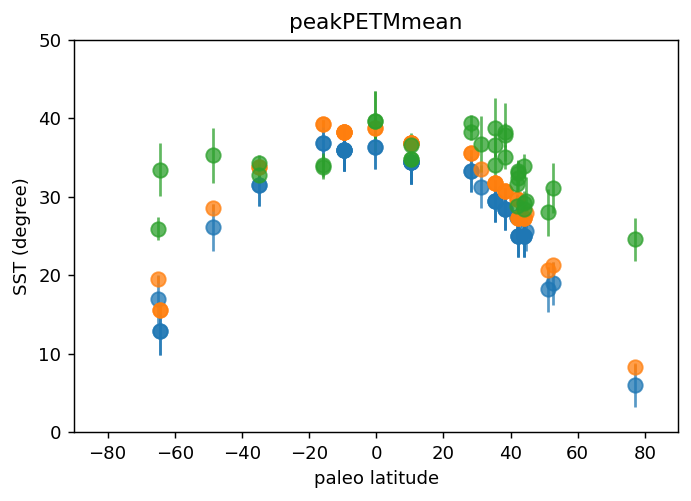

In [85]:
fig = plt.figure()

kwargs = dict(alpha=0.75, marker='o', markersize=8, linestyle='',label = 'Prior')

plt.errorbar(recon_sst[:,4], recon_sst[:,0], yerr = recon_sst[:,1],**kwargs)
plt.errorbar(recon_sst[:,4], recon_sst[:,2], yerr = recon_sst[:,3],**kwargs)

if reconi == 0:
    labelrecon0 = 'sst_prePETMmean'
    labelrecon1 = 'sst_prePETMvar'
    filename1 = 'petmproxy3slices_v0.0.12_sst_DA_prePETM.csv'
elif reconi == 1:
    labelrecon0 = 'sst_peakPETMmean'
    labelrecon1 = 'sst_peakPETMvar'
    filename1 = 'petmproxy3slices_v0.0.12_sst_DA_peakPETM.csv'
plt.errorbar(proxies['latbc'][:], proxies[labelrecon0][:], yerr = np.sqrt(proxies[labelrecon1][:]),**kwargs)

plt.xlim([-90, 90])
plt.ylim([0, 50])
plt.xlabel('paleo latitude')
plt.ylabel('SST (degree)')
plt.title(labelrecon0[4:])
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':130})

datad = proxies[labelrecon0][:]
modeld = recon_sst[:,0]
analysisd = recon_sst[:,2]

print('RMSE: prior vs proxy')
print(np.sqrt(np.nanmean((modeld - datad) ** 2, axis=0)))
print('RMSE: analysis vs proxy')
print(np.sqrt(np.nanmean((analysisd - datad) ** 2, axis=0)))
print('CE: prior vs proxy')
print(DeepDA_psm.CE_NS70(datad, modeld, 1))
print('CE: analysis vs proxy')
print(DeepDA_psm.CE_NS70(datad, analysisd, 1))

cols = ['sst_prior', 'sst_prior_std', 'sst_analysis', 'sst_analysis_std','paleolat']
df = proxy_select.join(pandas.DataFrame(recon_sst,columns=cols))

dirdir = yml_dict['core']['proj_dir']+'/wrk/' + filename1
df.to_csv(dirdir,index = False)

 ########## Read proxies database ########## 


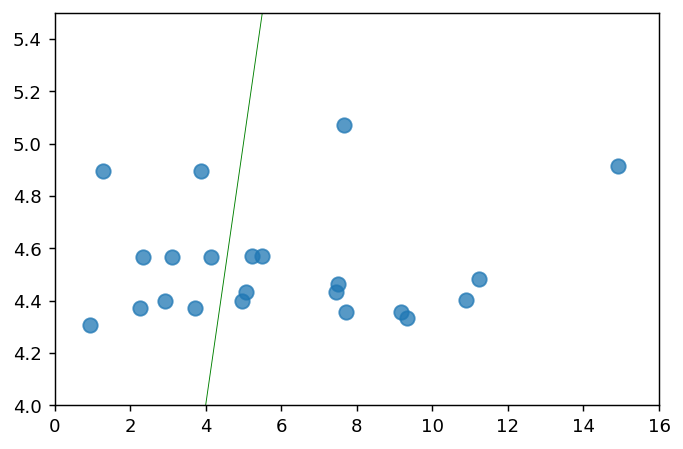

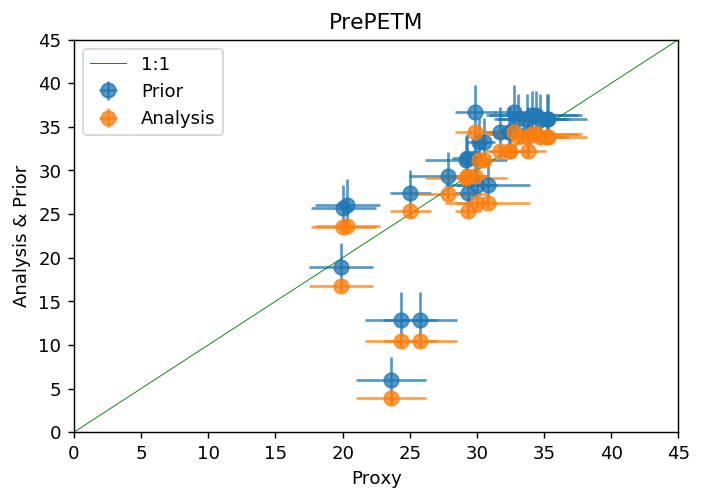

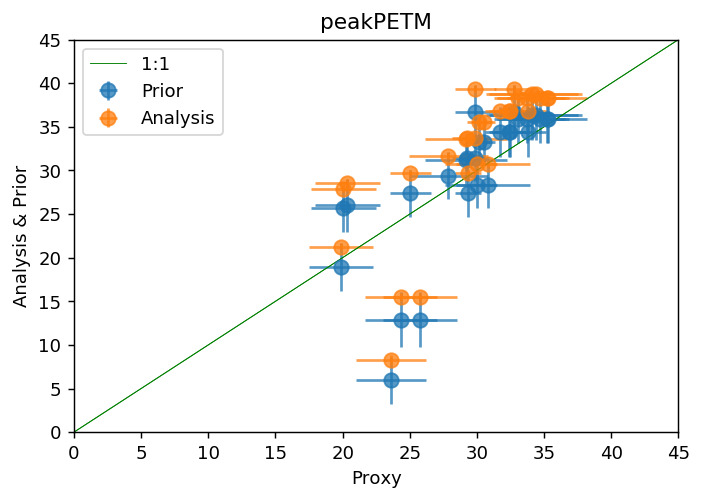

In [121]:
sstproxyfilesum = 'petmproxy3slices_v0.0.12_sst_DA_prePETM -peakPETM.csv'
proxy_rawfile1 = yml_dict['core']['proj_dir']+'/wrk/' + sstproxyfilesum 
lim1 = 0
lim2 = 45
print(' ########## Read proxies database ########## ')
### read proxies database ###
proxies1 = pandas.read_csv(proxy_rawfile1)
data1 = proxies['sst_peakPETMmean'][:] - proxies['sst_prePETMmean'][:]
analysis1 = proxies['sst_analysis_peak'][:] - proxies['sst_analysis_pre'][:]

fig = plt.figure()
kwargs = dict(alpha=0.75, marker='o', markersize=8, linestyle='',label = 'Prior')
plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)
plt.plot(data1,analysis1,**kwargs)
plt.xlim([0, 16])
plt.ylim([4, 5.5])

fig = plt.figure()
plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)
plt.errorbar(proxies1['sst_prePETMmean'][:], xerr = np.sqrt(proxies1['sst_prePETMvar'][:]), y=proxies1['sst_prior'][:], yerr = proxies1['sst_prior_std'][:],**kwargs)
plt.errorbar(proxies1['sst_prePETMmean'][:], xerr = np.sqrt(proxies1['sst_prePETMvar'][:]), y=proxies1['sst_analysis_pre'][:], yerr = proxies1['sst_analysis_std_pre'][:],**kwargs)
plt.xlim([lim1, lim2])
plt.ylim([lim1, lim2])
plt.legend(['1:1','Prior','Analysis'])
plt.xlabel('Proxy')
plt.ylabel('Analysis & Prior')
plt.title('PrePETM')
fig = plt.figure()
plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)
plt.errorbar(proxies1['sst_prePETMmean'][:], xerr = np.sqrt(proxies1['sst_prePETMvar'][:]), y=proxies1['sst_prior'][:], yerr = proxies1['sst_prior_std'][:],**kwargs)
plt.errorbar(proxies1['sst_prePETMmean'][:], xerr = np.sqrt(proxies1['sst_prePETMvar'][:]), y=proxies1['sst_analysis_peak'][:], yerr = proxies1['sst_analysis_std_peak'][:],**kwargs)
plt.xlim([lim1, lim2])
plt.ylim([lim1, lim2])
plt.legend(['1:1','Prior','Analysis'])
plt.xlabel('Proxy')
plt.ylabel('Analysis & Prior')
plt.title('peakPETM')
plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)


 /mnt/c/Users/mul450/Dropbox/git/deepDA/mlwrk/wrk/petmproxy3slices_v0.0.12_sst_DA_prePETM-peakPETM.csv
 len is 41
RMSE: prior vs proxy
3.721102633944145
RMSE: analysis vs proxy
3.780090821716504
CE: prior vs proxy
-0.1228003137174396
CE: analysis vs proxy
-0.15868049659683559


(4, 5.5)

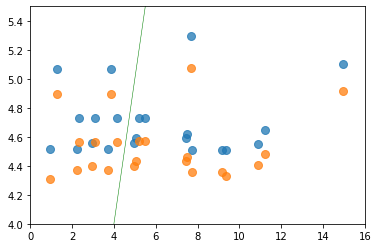

In [156]:
# read final data, plot data model comparison

file1 = yml_dict['core']['proj_dir']+'/wrk/' + 'petmproxy3slices_v0.0.12_sst_DA_prePETM-peakPETM.csv'
prox = proxies = pandas.read_csv(file1)
proxies_len0 = len(prox)

print(' {}'.format(file1))
print(' len is {}'.format(proxies_len0))
#print(' shape of proxy file {}'.format(prox.shape))

lat = prox['latbc'][:]
# pre = 0; peak = 1; e = std
data0 = prox['sst_prePETMmean'][:]
data0e = np.sqrt(prox['sst_prePETMvar'][:])
data1 = prox['sst_peakPETMmean'][:]
data1e = np.sqrt(prox['sst_peakPETMvar'][:])

analysis0 = prox['sst_analysispre'][:]
analysis0e = np.sqrt(prox['sst_analysis_stdpre'][:])
analysis1 = prox['sst_analysispeak'][:]
analysis1e = np.sqrt(prox['sst_analysis_stdpeak'][:])

model0e = np.sqrt(prox['sst_007std'][:])
model0 = prox['sst_007'][:]
model1 = prox['sst_008'][:]
model1e = np.sqrt(prox['sst_008std'][:])

datad = data1 - data0
modeld = model1 - model0
analysisd = analysis1 - analysis0

print('RMSE: prior vs proxy')
print(np.sqrt(np.nanmean((modeld - datad) ** 2, axis=0)))
print('RMSE: analysis vs proxy')
print(np.sqrt(np.nanmean((analysisd - datad) ** 2, axis=0)))
print('CE: prior vs proxy')
print(DeepDA_psm.CE_NS70(datad, modeld, 1))
print('CE: analysis vs proxy')
print(DeepDA_psm.CE_NS70(datad, analysisd, 1))


lim1 = 0
lim2 = 45
fig = plt.figure()
kwargs = dict(alpha=0.75, marker='o', markersize=8, linestyle='',label = 'Prior')
plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)
plt.plot(datad,modeld,**kwargs)
plt.plot(datad,analysisd,**kwargs)
plt.xlim([0, 16])
plt.ylim([4, 5.5])